## ПРОЕКТ ДЛЯ «ВИКИШОП»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В нашем распоряжении набор данных с разметкой о токсичности правок.

### ЗАДАЧА ПРОЕКТА

Задача проекта - обучить модель классифицировать комментарии на позитивные и негативные.\
Нужно построить модель со значением метрики качества F1 не меньше 0.75. 

### ПЛАН ПРОЕКТА

1. [Загрузка и изучение данных](#1)
2. [Подготовка данных](#2)
3. [Обучение моделей](#3)
4. [Общий вывод](#4)

<a id='1'></a>
# Загрузка и изучение данных

## Получение данных из файла, запись в датафрейм

In [1]:
!pip install jupyter_black -q

In [2]:
!pip install -Uq scikit-learn

In [3]:
!pip install shap -q

Импортируем необходимые библиотеки

In [4]:
# импорт pandas и необходимых библиотек
import jupyter_black
import nltk
import numpy as np
import os
import pandas as pd
import re
import shap

import transformers
import warnings

from nltk import pos_tag
from nltk.corpus import stopwords as nltk_stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler,
    StandardScaler,
)
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")

jupyter_black.load()
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")
nltk.download("averaged_perceptron_tagger_eng")

stopwords = set(nltk_stopwords.words("english"))
tqdm.pandas()

RANDOM_STATE = 42
TEST_SIZE = 0.1

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Откроем файл, прочтем и запишем в переменную.

In [5]:
# объявление переменных
toxic = "datatset.csv"
user_path = "..."
general_path = "..."


# функция для чтения файлов
def get_read_file(general_path, user_path, file):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(path1, index_col=["Unnamed: 0"])
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(path2, index_col=["Unnamed: 0"])
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную autos_df
toxic_df = get_read_file(general_path, user_path, toxic)

***

**ВЫВОД:**

1. Данные получены и записаны в датафрейм ***toxic_df***

## Изучение данных

### Изучение общей информации

Изучим общую информацию о полученном датафрейме

In [6]:
# вывод первых 5-ти строчек датафрейма
toxic_df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
# вывод основной информации о датафрейме
toxic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проверим данные на пропущенные значения

In [8]:
# вывод пропусков по столбцам
toxic_df.isna().sum().sort_values(ascending=False)

text     0
toxic    0
dtype: int64

Выведем количество явных дубликатов

In [9]:
# вывод количества явных дубликатов датафрейма
print(toxic_df.duplicated().sum())

0


Выведем количество значений таргета

In [10]:
# вывод количества значений
toxic_df["toxic"].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

***

***ВЫВОД:***

1. Пропусков в данных нет.
2. Явных дубликатов в данных нет.
3. В нумерации индексов присутствуют пропущенные значения.
4. Наблюдается существенный дисбаланс классов таргета в сторону не токсичных комментариев.

### Изучение текстов комментариев

Обратим внимание на тексты комментариев.

In [11]:
# вывод 10 полных комментов
for text in toxic_df.sample(10, random_state=RANDOM_STATE)["text"].tolist():
    print(text)
    print("--------------------------------")

Sometime back, I just happened to log on to www.izoom.in with a friend’s reference and I was amazed to see the concept Fresh Ideas Entertainment has come up with. So many deals… all under one roof. This website is very user friendly and easy to use and is fun to be on.
You have Gossip, Games, Facts… Another exciting feature to add to it is Face of the Week… Every week, 4 new faces are selected and put up as izoom faces. It’s great to have been selected in four out of a group of millions. 
This new start up has already got many a deals in its kitty. Few of them being TheFortune Hotel, The Beach… are my personal favorites. izoom.in has a USP of mobile coupons. Coupons are available even when a user cannot access internet. You just need to SMS izoom support to 56767 and you get attended immediately.
All I can say is izoom.in is a must visit website for everyone before they go out for shopping or dining or for outing.
Cheers!!!
--------------------------------
"

The latest edit is much be

***

***ВЫВОД:***

1. В тексте наряду со знаками препинания, спецсимволами и цифрами присутствуют наименования месяцев (в датах),\
   а также ссылки на сайты и email

<a id='2'></a>
# Подготовка данных

Проведём очистку текстов комментариев от лишних  символов и слов.\
Для этого используем токенизацию текстов, регулярные выражения и лемматизацию.

In [12]:
# инициализация лемматизатора
wnl = WordNetLemmatizer()

In [13]:
# объявление функкции для очистки текста
def get_clear_text(text):
    text = re.sub(
        r"(January|February|March|April|May|June|July|August|September|October|November|December)",
        "",
        text,
    )  # очистка от слов в списке
    text = re.sub(r"UTC", "", text)  # очистка от слова
    text = re.sub(r"http\S+|www.\S+", "", text)  # очистка от ссылок сайтов
    text = re.sub(r"\S+@\S+", "", text)  # очистка от email
    text = re.sub(r"[^a-zA-Z]", " ", text)  # очистка от символов
    clear_text = " ".join(text.split())  # очистка от лишних пробелов
    return clear_text.lower()


def penn2morphy(penntag):
    morphy_tag = {"NN": "n", "JJ": "a", "VB": "v", "RB": "r"}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return "n"


# объявление фнкции для лемматизации текста
def get_lemm_text(text):
    return [
        wnl.lemmatize(word, pos=penn2morphy(tag))
        for word, tag in pos_tag(word_tokenize(text))
    ]

Запишем очищенный текст в признак `'clear_text'`

In [14]:
# запись в новый столбец
toxic_df["clear_text"] = toxic_df.text.progress_apply(lambda x: get_clear_text(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

Запишем лемматизированный текст в признак `'lemm_text'`

In [15]:
toxic_df["lemm_text"] = toxic_df.clear_text.progress_apply(lambda x: get_lemm_text(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

Проведём очистку текстов от стоп-слов с записью в новый признак `'lemm_text_no_stop'`

In [16]:
# запись в новый столбец
toxic_df["lemm_text_no_stop"] = toxic_df["lemm_text"].progress_apply(
    lambda x: " ".join(
        [word for word in x if word not in (stopwords) and word.isalpha()]
    )
)

  0%|          | 0/159292 [00:00<?, ?it/s]

Создадим новый признак `'count_simbols'`, посчитав количество символов в тексте

In [17]:
# запись в новый столбец
toxic_df["count_simbols"] = toxic_df["lemm_text_no_stop"].str.len()

Создадим новый признак `'count_words'`, посчитав количество слов в тексте

In [18]:
# запись в новый столбец
toxic_df["count_words"] = toxic_df["lemm_text_no_stop"].apply(lambda x: len(x.split()))

Проанализируем тональность текстов комментариев.

In [19]:
# инициализация анализатора
sia = SentimentIntensityAnalyzer()

In [20]:
# объявление функции для определения тональности текста
def get_ton(x):
    if sia.polarity_scores(x)["compound"] > 0:
        return "positive"
    elif sia.polarity_scores(x)["compound"] < 0:
        return "negative"
    else:
        return "neutral"

Запишем тональность текстов в новый признак `'ton'`

In [21]:
# запись в новый столбец
toxic_df["ton"] = toxic_df["lemm_text_no_stop"].progress_apply(lambda x: get_ton(x))

  0%|          | 0/159292 [00:00<?, ?it/s]

Проверим создание новых признаков

In [22]:
# вывод первых 5-ти строчек датафрейма
toxic_df.head()

,text,toxic,clear_text,lemm_text,lemm_text_no_stop,count_simbols,count_words,ton
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, make, under, my...",explanation edits make username hardcore metal...,152,23,positive
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,"[d, aww, he, match, this, background, colour, ...",aww match background colour seemingly stick th...,55,8,positive
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,"[hey, man, i, m, really, not, try, to, edit, w...",hey man really try edit war guy constantly rem...,132,21,negative
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,"[more, i, can, t, make, any, real, suggestion,...",make real suggestion improvement wonder sectio...,352,52,positive
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,"[you, sir, be, my, hero, any, chance, you, rem...",sir hero chance remember page,29,5,positive


***

***ВЫВОД:***

1. Предварительно тексты комментариев были очищены от:
    - названий месяцев в датах
    - указания UTC
    - ссылок на сайты
    - email
    - символов кроме букв английского языка
2. Текст комментариев был приведён к нижнему регистру и лемматизирован.
3. Были созданы новые количественные признаки:
    - `'count_simbols'`
    - `'count_words'`
4. Была определена тональность текстов и записана в новый признак `'ton'`

<a id='3'></a>
# Обучение моделей

## Подготовка датафрейма

В датафрейме выделим входные и целевой признаки

In [23]:
# выделение признаков
X = toxic_df.drop(columns=["toxic", "text", "lemm_text", "clear_text"])
y = toxic_df["toxic"]

Разделим датафрейм на тренировочную и тестовую части

In [24]:
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y
)

Проверим разделение

In [25]:
# вывод размеров датафреймов
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((143362, 4), (15930, 4), (143362,), (15930,))

Преобразуем таргет тренировочной и тестовой частей в массивы numpy

In [26]:
# преобразование в массивы NumPy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Создание pipeline

Так как тагрет - категориальный признак, будем решать задачу классификации.

Для построения модели используем пайплайны.\
Для подготовки данных будем использовать ColumnTransformer.\
Для кодирования категориальных признаков будем использовать кодировщики:
 - OrdinalEncoder()

Для масштабирования количественных признаков будем использовать скейлеры:
 - MinMaxScaler()
 - StandardScaler()
 - RobustScaler()
 - и аргумент "passthrough" - вариант без масштабирования.

Для векторизации текстов комментариев будем использовать векторизатор:
 - TfidfVectorizer()

Для оценки адекватности модели будем использовать DummyClassifier()

Создадим общий pipeline для подготовки данных и итоговый pipeline

In [27]:
# создание общего pipeline для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(), "lemm_text_no_stop"),
        (
            "ord",
            OrdinalEncoder(
                categories=[
                    ["negative", "neutral", "positive"],
                ]
            ),
            ["ton"],
        ),
        ("num", StandardScaler(), ["count_simbols", "count_words"]),
    ],
    remainder="passthrough",
)

In [28]:
# создание итогового pipeline с инициализацией модели
pipe_final = Pipeline(
    [
        ("preprocessor", data_preprocessor),
        ("models", DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)),
    ]
)

Опишем модели с гиперпараметрами

In [29]:
param_grid = [
    # словарь для модели LogisticRegression()
    {
        "models": [LogisticRegression(random_state=RANDOM_STATE)],
        "models__C": range(5, 18, 3),
    },
    # словарь для модели RandomForestClassifier()
    {
        "models": [RandomForestClassifier(random_state=RANDOM_STATE)],
        "models__max_depth": range(2, 20, 2),
        "models__n_estimators": range(3, 20, 2),
    },
    # словарь для модели GradientBoostingClassifier()
    {
        "models": [GradientBoostingClassifier()],
        "models__max_depth": range(3, 7, 3),
        "models__min_samples_split": range(4, 11, 2),
        "models__n_estimators": range(11, 20, 2),
    },
]

## Подбор модели и получение метрики качества

Выполним подбор гиперпараметров к модели LogisticRegression()\
и оценим качество модели метрикой F1

In [30]:
# подбор лучшей модели с гиперпараметрами
model_lr = RandomizedSearchCV(
    pipe_final,
    param_grid[0],
    scoring="f1",
    n_iter=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
model_lr.fit(X_train, y_train)

print("Лучшая модель и её параметры:\n\n", model_lr.best_estimator_)
print(f"Качество модели по метрике F1 - {round(model_lr.best_score_, 3)}")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf', TfidfVectorizer(),
                                                  'lemm_text_no_stop'),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['negative',
                                                                              'neutral',
                                                                              'positive']]),
                                                  ['ton']),
                                                 ('num', StandardScaler(),
                                                  ['count_simbols',
                                                   'count_words'])])),
                ('models', LogisticRegression(C=14, random_state=42))])
Качество модели по метрике F1 - 0.774


Проверим модель на адекватность dummy-моделью

In [31]:
# проверка на адекватность
model = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
distributions = dict(strategy=["uniform"])

model_dummy = RandomizedSearchCV(
    model,
    distributions,
    scoring="f1",
    n_iter=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
model_dummy.fit(X_train, y_train)

print("Модель dummy и её параметры:\n\n", model_dummy.best_estimator_)
print(f"Качество модели по метрике F1 - {round(model_dummy.best_score_, 3)}")

Модель dummy и её параметры:

 DummyClassifier(random_state=42, strategy='uniform')
Качество модели по метрике F1 - 0.171


Оценим качество обученной модели на тестовой выборке

In [32]:
# получение предсказаний на тестовой выборке
y_pred = model_lr.predict(X_test)
score = f1_score(y_test, y_pred)
print(f"Качество модели по метрике F1 на тестовой выборке - {round(score, 3)}")

Качество модели по метрике F1 на тестовой выборке - 0.777


Подбор гиперпараметров других описанных моделей занимает много времени.\
Кроме того, метрика качества при этом низкая.

Оценим общую значимость значимость признаков.\
Для этого воспользуемся обученной лучшей моделью.

In [33]:
# переформирование предсказания лучшей модели в DataFrame
pred_df = lambda x: model_lr.best_estimator_.predict(
    pd.DataFrame(x, columns=X_train.columns)
)

In [34]:
# создаем объект explainer для модели
explainer = shap.KernelExplainer(pred_df, X_test)
shap_values = explainer.shap_values(X_test[:100], nsamples=50)

  0%|          | 0/100 [00:00<?, ?it/s]

Оценим общий вклад признаков в прознозы модели.

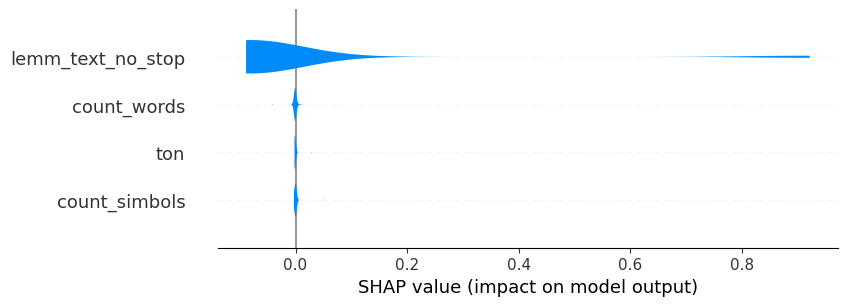

In [35]:
# получение имён признаков
feat_names = list(X.columns)
# построение графика
shap.plots.violin(shap_values, feature_names=feat_names)

Как видно на графике вклад новых признаков минимален.\
Попробуем построить модель без этих новых признаков.

In [36]:
# создание общего pipeline для подготовки данных
data_preprocessor2 = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(), "lemm_text_no_stop"),
    ]
)
# создание итогового pipeline с инициализацией модели
pipe_final2 = Pipeline(
    [
        ("preprocessor", data_preprocessor2),
        ("models", DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)),
    ]
)

In [37]:
# удаление новых признаков
X_train2 = X_train.drop(columns=["ton", "count_words", "count_simbols"])

In [38]:
# подбор лучшей модели с гиперпараметрами
model_lr2 = RandomizedSearchCV(
    pipe_final2,
    param_grid[0],
    scoring="f1",
    n_iter=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
model_lr2.fit(X_train2, y_train)

print("Лучшая модель и её параметры:\n\n", model_lr2.best_estimator_)
print(f"Качество модели по метрике F1 - {round(model_lr2.best_score_, 3)}")

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'lemm_text_no_stop')])),
                ('models', LogisticRegression(C=8, random_state=42))])
Качество модели по метрике F1 - 0.772


Удаление новых признаков не привело к улучшению качества модели.

***

***ВЫВОД:***

1. Были обучены модели с гиперпараметрами:
   - LogisticRegression() с ***C***
   - RandomForestClassifier() с ***max_depth***, ***n_estimators***
   - GradientBoostingClassifier() с ***max_depth***, ***min_samples_split***, ***n_estimators***
2. Для подбора лучшей модели с гиперпараметрами использован
   - RandomizedSearchCV()
3. Для оценки качества работы модели применили метрику F1
4. Лучшая модель по метрике качества **LogisticRegression()** с гиперпараметром **C** = 14
5. Метрика качества F1 для лучшей модели составляет при кросс-валидации 0.774
6. Модель **LogisticRegression()** была проверена на адекватность dummy-моделью
7. Метрика качества F1 для лучшей модели на тестовой выборке составила 0.777
8. Модели RandomForestClassifier() и GradientBoostingClassifier() не прошли оценку качеством.
9. Были оценены вклады новых признаков в предсказания модели.

<a id='4'></a>
# ОБЩИЙ ВЫВОД

**ВХОДНЫЕ ДАННЫЕ:**
1. Исследование проведено на базе данных интернет-магазин «Викишоп»
2. Данные представлены файлом toxic_comments.csv
3. Данные получены и записаны в датафрейм ***toxic_df***


**НА ЭТАПЕ ИЗУЧЕНИЯ ДАННЫХ:**
1. Пропусков в данных нет.
2. Явных дубликатов в данных нет.
3. В нумерации индексов присутствуют пропущенные значения.
4. Наблюдается существенный дисбаланс классов таргета в сторону не токсичных комментариев.


**НА ЭТАПЕ ПОДГОТОВКИ ДАННЫХ**
1. Предварительно тексты комментариев были очищены от:
    - названий месяцев в датах
    - указания UTC
    - ссылок на сайты
    - email
    - символов кроме букв английского языка
2. Текст комментариев был приведён к нижнему регистру и лемматизирован.
3. Были созданы новые количественные признаки:
    - `'count_simbols'`
    - `'count_words'`
4. Была определена тональность текстов и записана в новый признак `'ton'`


**НА ЭТАПЕ ОБУЧЕНИЯ МОДЕЛЕЙ**
1. Были обучены модели с гиперпараметрами:
   - LogisticRegression() с ***C***
   - RandomForestClassifier() с ***max_depth***, ***n_estimators***
   - GradientBoostingClassifier() с ***max_depth***, ***min_samples_split***, ***n_estimators***
2. Для подбора лучшей модели с гиперпараметрами использован
   - RandomizedSearchCV()
3. Для оценки качества работы модели применили метрику F1
4. Лучшая модель по метрике качества **LogisticRegression()** с гиперпараметром **C** = 2.5
5. Метрика качества F1 для лучшей модели составляет при кросс-валидации 0.774
6. Модель **LogisticRegression()** была проверена на адекватность dummy-моделью
7. Метрика качества F1 для лучшей модели на тестовой выборке составила 0.777
8. Модели RandomForestClassifier() и GradientBoostingClassifier() не прошли оценку качеством.
9. Были оценены вклады новых признаков в предсказания модели.


**ВЫВОД**

Цель проекта - построить модель со значением метрики качества F1 не меньше 0.75 - достигнута.